In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

# Предобработка данных и преобразования
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from flaml import AutoML

from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)

from imblearn.pipeline import Pipeline

import shap

from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
import os

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

pd.options.mode.copy_on_write = True 


plt.rcParams["font.family"] = "Times New Roman"
sns.set_theme(
    font='Times New Roman',
    rc={
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 12,
    }
)

In [96]:
df = pd.read_excel("Dataset 1.xlsx")

# По заданию берем только АО "ПГК" в столбце 'Оператор'
df = df[df['Оператор'] == 'АО "ПГК"']

## EDA

In [97]:
df.head(5)

,Номер вагона,Номер накладной,Род вагона,Администрация собственника,Дата и время начала рейса,Государство отправления,Дорога отправления,Станция отправления,Дата и время окончания рейса,Государство назначения,Дорога назначения,Станция назначения,Грузоотправитель (ТГНЛ),Грузоотправитель,Грузоотправитель (ОКПО),Грузоотправитель (наим),Грузополучатель (ТГНЛ),Грузополучатель,Грузополучатель (ОКПО),Грузополучатель (наим),Наименование груза,Код груза ГНГ,Вес груза (кг),Пробег в груженом состоянии (км),Пробег в порожнем состоянии (км),Пробег общий (км),Норматив величины пробега (км),Остаток пробега (км),Ранее выгруженный груз,Станция операции,Дорога операции,Операция,Мнемокод операции,Дата и время операции,Тип парка,Дорога сдачи,Дорога приема,Индекс поезда,Номер поезда,Номер вагона в составе поезда,Номер парка,Номер пути,Нормативный срок доставки,Расстояние пройденное (км),Расстояние оставшееся (км),Расстояние общее (км),Время простоя под последней операцией (сутки:часы:минуты),Время простоя под последней операцией (сутки),Идентификатор отправки по досылке,Идентификатор накладной по досылке,Дата и время отправления (АСОУП) со станции приема груза к перевозке,Дата и время прибытия (АСОУП) на станцию назначения,Идентификатор отправки,Идентификатор накладной,Дата и время назначения состояния,Состояние вагона,Причина назначения состояния,Станция назначения состояния,Дата следующего планового ремонта,Вид следующего планового ремонта,Депо последнего кап. ремонта,Дата последнего кап. ремонта,Депо последнего деп. ремонта,Дата последнего деп. ремонта,Дорога приписки,Депо приписки,Дата исключения,Причина запрета на курсирование,Номер вагона до перенумерации,Собственник,Собственник (ОКПО),Собственник (локальный код),Станция приписки,Признак порога,Признак аренды,Утв. дата продления срока службы,Арендатор,Арендатор (ОКПО),Арендатор (локальный код),Станция приписки аренды,Дата окончания аренды,Оператор по доверенности,Оператор по доверенности (ОКПО),Род вагона_1,Условный тип вагона,Количество осей вагона,Депо исключения вагона,Причина исключения вагона,Вид планового ремонта,Дата планового ремонта,Дата и время ввода данных,Вид ремонта,Дорога ремонта,Депо ремонта,Неисправность 1,Дата и время неисправности,Дата и время начала ремонта,Дата и время окончания ремонта,Станция передачи-отцепки,Номер уведомления ВУ-23,Номер уведомления ВУ-36,Перевозка завершена,Оператор,Дата завершения перевозки,Срок доставки факт,Простой,Дата завершения,Дата начала,Дата актуальность
0,22793426,ЭХ920086,Крытые (20),РЖД (20),2024-02-18 09:37:00,Российская Федерация,Свердловская (76),Заячья Горка (769407),NaT,Российская Федерация (643),Свердловская (76),Кунгур (763701),4430,"АО ""ПГК"" (56738657)",56738657,"АО ""ПГК""",9285,"ООО ""КНАУФ ГИПС КУНГУР"" (56798576)",56798576,"ООО ""КНАУФ ГИПС КУНГУР""","Вагоны железнодорожные всякие, перевозимые на ...",0,0,78417,26386,104803,110000,5197,"Изделия кислотоупорные и огнеупорные, не поиме...",Чусовская (767308),Свердловская (76),Исключение вагона из состава поезда (3),ИСКП,2024-02-21 01:25:00,"Местный, Порожний, Вагон рабочего парка",ЗАБАЙКАЛЬСКАЯ 94,ЗАБАЙКАЛЬСКАЯ 94,769002 104 767308 (БЕРЕЗНИКИ-СР+104+ЧУСОВСКАЯ),3552,12,1 (1),(7),2024-02-23,211,236,447,0:11:37,0,NaN,0,2024-02-19 15:54:00,NaT,2076ЭX920086,1.474951e+09,2024-01-02 15:08:00,ВАГОН PП,Текущий ремонт 1 (3),САНКТ-ПЕТЕРБУРГ-СОРТ.-МОСКОВСКИЙ (30006),2024-08-19,Коды для внутреннего использования железнодоро...,"ВРЗ Челябинск филиал ООО ""НВК"" (600)",2009-03-01,"Вологодский ВРЗ АО ""ВРК-1"" (4)",2021-10-06,МОСКОВСКАЯ (17),0,NaN,0,0,"АО ""ПГК""",56738657,171714,ЩЕЛКОВО (235507),ВАГОН РЕМОНТИРУЕТСЯ ПО ПРОБЕГУ,NaN,2024-08-19,NaN,0,0,- - - (0),NaT,NaN,0,Крытые (20),(1),4,(0),(0),Исключение из инвентарного парка (8),2024-08-19,2024-01-02 15:09:00,Текущий ремонт 1 (3),ОКТЯБРЬСКАЯ (1),"ВЧДЭ-6 С-Петербург Сортиров. Московский ОАО ""Р...",Наличие досок пола крытых вагонов и платформ н...,2024-01-02 14:35:00,2024-01-02 14:42:00,2024-01-02 15:08:00,САНКТ-ПЕТЕРБУРГ-СОРТ.-МОСКОВСКИЙ (300

In [98]:
df.tail(5)

,Номер вагона,Номер накладной,Род вагона,Администрация собственника,Дата и время начала рейса,Государство отправления,Дорога отправления,Станция отправления,Дата и время окончания рейса,Государство назначения,Дорога назначения,Станция назначения,Грузоотправитель (ТГНЛ),Грузоотправитель,Грузоотправитель (ОКПО),Грузоотправитель (наим),Грузополучатель (ТГНЛ),Грузополучатель,Грузополучатель (ОКПО),Грузополучатель (наим),Наименование груза,Код груза ГНГ,Вес груза (кг),Пробег в груженом состоянии (км),Пробег в порожнем состоянии (км),Пробег общий (км),Норматив величины пробега (км),Остаток пробега (км),Ранее выгруженный груз,Станция операции,Дорога операции,Операция,Мнемокод операции,Дата и время операции,Тип парка,Дорога сдачи,Дорога приема,Индекс поезда,Номер поезда,Номер вагона в составе поезда,Номер парка,Номер пути,Нормативный срок доставки,Расстояние пройденное (км),Расстояние оставшееся (км),Расстояние общее (км),Время простоя под последней операцией (сутки:часы:минуты),Время простоя под последней операцией (сутки),Идентификатор отправки по досылке,Идентификатор накладной по досылке,Дата и время отправления (АСОУП) со станции приема груза к перевозке,Дата и время прибытия (АСОУП) на станцию назначения,Идентификатор отправки,Идентификатор накладной,Дата и время назначения состояния,Состояние вагона,Причина назначения состояния,Станция назначения состояния,Дата следующего планового ремонта,Вид следующего планового ремонта,Депо последнего кап. ремонта,Дата последнего кап. ремонта,Депо последнего деп. ремонта,Дата последнего деп. ремонта,Дорога приписки,Депо приписки,Дата исключения,Причина запрета на курсирование,Номер вагона до перенумерации,Собственник,Собственник (ОКПО),Собственник (локальный код),Станция приписки,Признак порога,Признак аренды,Утв. дата продления срока службы,Арендатор,Арендатор (ОКПО),Арендатор (локальный код),Станция приписки аренды,Дата окончания аренды,Оператор по доверенности,Оператор по доверенности (ОКПО),Род вагона_1,Условный тип вагона,Количество осей вагона,Депо исключения вагона,Причина исключения вагона,Вид планового ремонта,Дата планового ремонта,Дата и время ввода данных,Вид ремонта,Дорога ремонта,Депо ремонта,Неисправность 1,Дата и время неисправности,Дата и время начала ремонта,Дата и время окончания ремонта,Станция передачи-отцепки,Номер уведомления ВУ-23,Номер уведомления ВУ-36,Перевозка завершена,Оператор,Дата завершения перевозки,Срок доставки факт,Простой,Дата завершения,Дата начала,Дата актуальность
11435,52695947,ЭН235454,Крытые (20),РЖД (20),2023-09-05 14:12:00,Российская Федерация,Свердловская (76),Войновка (790408),2023-09-10 01:25:00,Российская Федерация (643),Южно-Уральская (80),Металлургическая (801208),4430,"АО ""ПГК"" (56738657)",56738657,"АО ""ПГК""",9446,"ООО ""КНАУФ ГИПС ЧЕЛЯБИНСК"" (5800969)",5800969,"ООО ""КНАУФ ГИПС ЧЕЛЯБИНСК""","Вагоны железнодорожные всякие, перевозимые на ...",0,0,46782,11916,58698,160000,101302,"Изделия гипсоволокнистые и гипсовые, не поимен...",Металлургическая (801208),Южно-Уральская (80),Подача вагона на подъездной путь (80),ПВПП,2023-09-14 06:58:00,"Местный, Порожний, Вагон рабочего парка",АО 'АК'ЖЕЛЕЗНЫЕ ДОРОГИ ЯКУТИИ' 91,ДАЛЬНЕВОСТОЧНАЯ 96,800008 796 801208 (ЧЕЛЯБИНСК-ГЛ+796+МЕТАЛЛУРГИЧ.),3164,9,4Г (4),(0),2023-09-10,441,0,441,0:1:2,0,NaN,0,2023-09-06 11:44:00,2023-09-10 00:35:00,2076ЭH235454,1.426683e+09,2022-09-13 13:20:00,ВАГОН PП,Деповской ремонт (1),САНКТ-ПЕТЕРБУРГ-СОРТ.-МОСКОВСКИЙ (30006),2025-09-13,Капитальный ремонт (2),"ВЧДр Инская АО ""ВРК-1"" (626)",2011-04-30,"ВЧДр Спб-Мск-Сортировочный АО ""ВРК-1"" (321)",2022-09-13,МОСКОВСКАЯ (17),0,NaN,0,28319093,"АО ""ПГК""",56738657,171714,ЛУЖКИ-ОРЛОВСКИЕ (205608),ВАГОН РЕМОНТИРУЕТСЯ ПО ПРОБЕГУ,NaN,2026-12-28,NaN,0,0,- - - (0),NaT,NaN,0,Крытые (20),(1),4,(0),(0),Капитальный ремонт (2),2025-09-13,2022-09-13 16:04:00,Деповской ремонт (1),ОКТЯБРЬСКАЯ (1),"ВЧДр Спб-Мск-Сортировочный АО ""ВРК-1"" (321)",Иcтeк кaлендарный cpoк дeпoвcкого peмoнтa (570),2022-09-12 15:15:00,2022-09-12 16:00:00,2022-09-13 

In [99]:
df.shape

(5068, 109)

### Пропуски

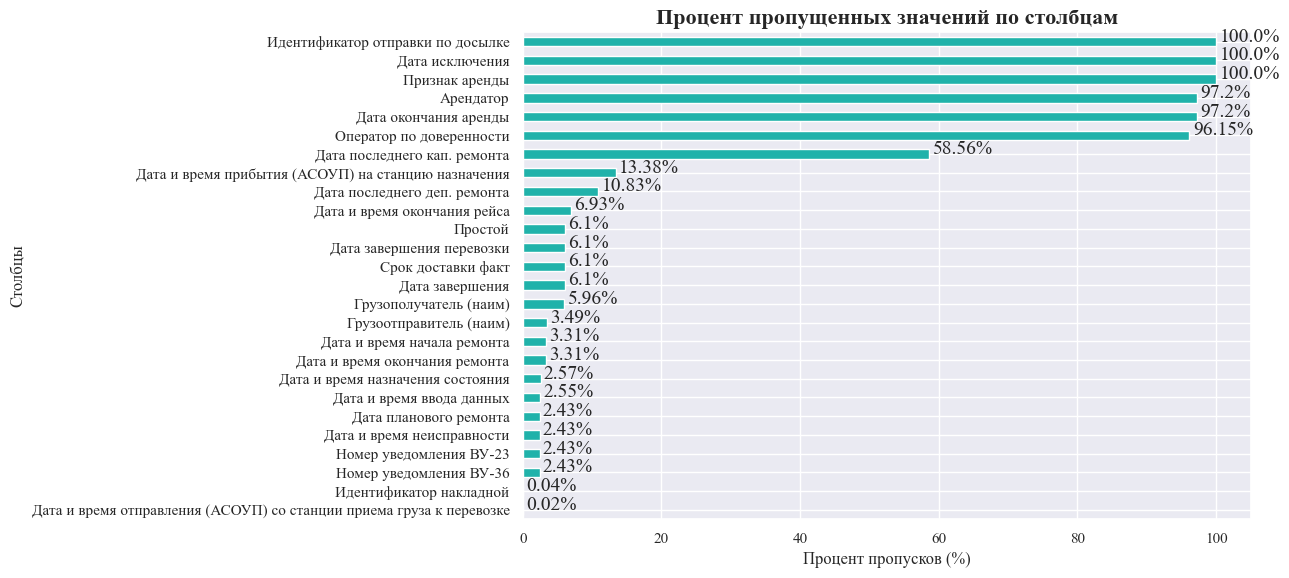

47.26716653512233
Нижняя граница выбросов: -64.52496053670086
Верхняя граница выбросов: 114.34244277821624


In [100]:
# Смотрим распределение пропущенных значений по столбцам
missing_percent = df.isnull().sum() / len(df) * 100

# Фильтруем и сортируем столбцы с пропусками > 0%
missing_percent = missing_percent[missing_percent > 0].sort_values()

# Строим ГОРИЗОНТАЛЬНУЮ столбчатую диаграмму
ax = missing_percent.plot(
    kind='barh',  # horizontal bar chart
    figsize=(13, 6),
    color='lightseagreen',
    xlabel='Процент пропусков (%)',
    ylabel='Столбцы'
)

plt.title('Процент пропущенных значений по столбцам', weight='bold')
plt.grid(True)

# Добавляем подписи значений
for i, v in enumerate(missing_percent):
    ax.text(v + 0.5, i, f"{round(v, 2)}%", va='baseline')

plt.tight_layout()
plt.show()


Q1 = missing_percent.quantile(0.25)
Q3 = missing_percent.quantile(0.75)
print(Q3)
IQR = Q3 - Q1
# Пороги для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Нижняя граница выбросов: {lower_bound}")
print(f"Верхняя граница выбросов: {upper_bound}")

### Изучаем целевую переменную срок доставки факт

In [101]:
sns.boxplot(df['Срок доставки факт'], orient='h')
plt.title('Ящик с усами распределения "Срок доставки факт"', weight='bold')
Q1 = df['Срок доставки факт'].quantile(0.25)
Q3 = df['Срок доставки факт'].quantile(0.75)
IQR = Q3 - Q1
# Пороги для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Нижняя граница выбросов: {lower_bound}")
print(f"Верхняя граница выбросов: {upper_bound}")

Нижняя граница выбросов: -6.5
Верхняя граница выбросов: 21.5


In [102]:
print("'Срок доставки факт' распределение значений")
print("Аномалии (%): ", len(df[df['Срок доставки факт'] >= 21.5]) / len(df) * 100)
print("Норм значения (%):", len(df[ (df['Срок доставки факт'] >= 0) & (df['Срок доставки факт'] < 21.5)]) / len(df) * 100)
print("Пропуски (%): ", df['Срок доставки факт'].isna().sum() / len(df) * 100)

'Срок доставки факт' распределение значений
Аномалии (%):  4.360694554064719
Норм значения (%): 89.54222573007104
Пропуски (%):  6.097079715864246


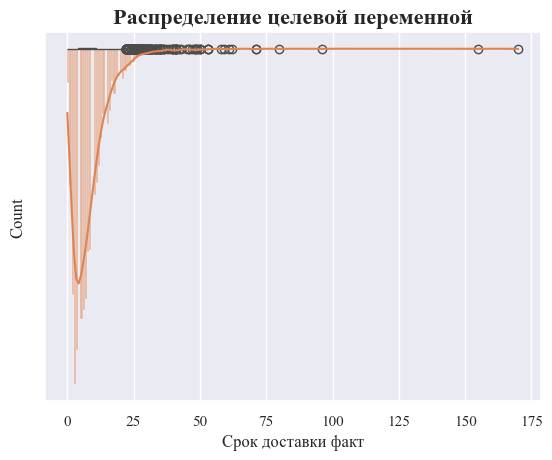

In [103]:
sns.histplot(df['Срок доставки факт'], kde=True)
plt.title('Распределение целевой переменной', weight='bold')
plt.show()

### Корреляция между целевой переменной и другими числовыми

In [104]:
plt.figure(figsize=(10, 10))
correlations = df.corr(numeric_only=True)['Срок доставки факт'].sort_values(ascending=False)
sns.heatmap(pd.DataFrame(correlations), annot=True)

<Axes: >

## Предобработка данных

In [105]:
# Дропаем столбцы с > 95% пропусков
df_cleaned = df.loc[:, df.isna().mean() < 0.95]

In [106]:
# Дропаем дубликаты
df_cleaned = df_cleaned.drop_duplicates()
df_cleaned.shape
# Дубликатов нет

(5068, 103)

In [107]:
# Дропаем столбцы с только одним уникальным значением
df_cleaned.drop([col for col in df_cleaned if df_cleaned[col].nunique()==1 and col != 'Оператор'], axis=1, inplace=True)

In [108]:
# Словарь-информатор об уникальных значениях столбцов : кол-во юник, сами юник, тип столбца
# ПОЛЕЗНАЯ ШТУКА!!!!
unique_dict = dict()
for col in df_cleaned.columns:
    nu = df_cleaned[col].nunique()
    u = df_cleaned[col].unique()
    ty = df_cleaned[col].dtype
    unique_dict[col] = [ty, nu, u]

In [109]:
# Столбцы с двумя уникальными значениями
for k in unique_dict.keys():
    if unique_dict[k][1] == 2:
        print(k, unique_dict[k])

Состояние вагона [dtype('O'), 2, array(['ВАГОН PП', 'ВАГОН НЕИСПРАВНЫЙ'], dtype=object)]
Оператор по доверенности (ОКПО) [dtype('int64'), 2, array([       0, 56738657], dtype=int64)]
Перевозка завершена [dtype('bool'), 2, array([False,  True])]


In [110]:
# Столбцы с тремя уникальными значениями
for k in unique_dict.keys():
    if unique_dict[k][1] == 3:
        print(k, unique_dict[k])

Вид следующего планового ремонта [dtype('O'), 3, array(['Коды для внутреннего использования железнодорожными администрациями (8)',
       'Деповской ремонт (1)', 'Капитальный ремонт (2)'], dtype=object)]
Признак порога [dtype('O'), 3, array(['ВАГОН РЕМОНТИРУЕТСЯ ПО ПРОБЕГУ',
       'ВАГОН НЕ РЕМОНТИРУЕТСЯ ПО ПРОБЕГУ', 'ЖЁЛТЫЙ ПОРОГ'], dtype=object)]


In [111]:
# Опять смотрим на пропуски
(df_cleaned.isnull().mean() * 100).sort_values(ascending=False)

Дата последнего кап. ремонта                                            58.563536
Дата и время прибытия (АСОУП) на станцию назначения                     13.378058
Дата последнего деп. ремонта                                            10.832676
Дата и время окончания рейса                                             6.925809
Простой                                                                  6.097080
Срок доставки факт                                                       6.097080
Дата завершения перевозки                                                6.097080
Дата завершения                                                          6.097080
Грузополучатель (наим)                                                   5.958958
Грузоотправитель (наим)                                                  3.492502
 Дата и время окончания ремонта                                          3.314917
 Дата и время начала ремонта                                             3.314917
Дата и время наз

### Функции для расчета корреляций

In [112]:
# Функция Крамера для категориальных переменных
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    
    denominator = min((k - 1), (r - 1))
    if denominator <= 0 or np.isnan(denominator):
        return 0.0  # or handle the error case appropriately
    return np.sqrt(phi2 / denominator)


# Фуункция корреляционная матрица Крамера
def cramers_corr_matrix(df):
    categories = df.columns
    corr_matrix = pd.DataFrame(index=categories, columns=categories)
    for i in categories:
        for j in categories:
            corr_matrix.loc[i, j] = cramers_v(df[i], df[j])
    return corr_matrix

Ручной и зрительный анализ дает лучшее понимание набора данных.

Проанализировав столбцы вручную, можно выделить несколько моментов:
* **Срок доставки факт** совпадает с **длительностью рейса**
* Покапавшись в интернете выяснилось, что многие данные из датасета коррелируют с сайтом про грузоперевозки (см https://online.freicon.ru/info/tariff-distance-calculation)
    * **Расстояние общее (км)** ~= расстояние между станциями - исходя из сопоставления вычесленных расстояний между станциями на сайте и значений столбца **Расстояние общее (км)** нашего датасета


Исходя из зрительного анализа датасета и логики можно выделить накие столбцы могут влять на **Срок доставки факт**. Естественно берем исторические данные, которые известны до прибытия поезда на станцию назначения (**Дата и время окончания рейса**).

**Это такие столбцы как**
1. **Расстояние общее (км)**
2. **Время простоя под последней операцией (сутки:часы:минуты)**
3. **Дорога отправления**, **Станция отправления**
3. **Дорога назначения**, **Станция назвачения**

## Подготовка данных

In [113]:
# Процент пропусков в нужных столбцах
print(round(df[['Дата и время начала рейса', 
    'Дата последнего деп. ремонта', 'Государство отправления', 'Государство назначения', 'Вес груза (кг)', 'Время простоя под последней операцией (сутки:часы:минуты)'
    ]].isnull().sum() / len(df) * 100, 2).sort_values(ascending=False))


# Обработаем пропуски в нужных нам столбцах для простроения новых фичей
df_cleaned = df_cleaned.dropna(subset=[
    'Пробег в груженом состоянии (км)', 'Дата и время начала рейса', 
    'Дата последнего деп. ремонта', 'Государство отправления', 'Государство назначения', 'Вес груза (кг)', 'Время простоя под последней операцией (сутки:часы:минуты)'
])

# Обработаем пропуски в целевой переменной
df_cleaned = df_cleaned.dropna(subset=['Срок доставки факт'])

Дата последнего деп. ремонта                                 10.83
Дата и время начала рейса                                     0.00
Государство отправления                                       0.00
Государство назначения                                        0.00
Вес груза (кг)                                                0.00
Время простоя под последней операцией (сутки:часы:минуты)     0.00
dtype: float64


In [114]:
# Фильтруем целевую переменную беря значения меньше 150
df_cleaned = df_cleaned.loc[df_cleaned['Срок доставки факт'] < 21.5]

In [115]:
# Изменение формата
df_cleaned['Дата и время окончания рейса'] = df_cleaned['Дата и время окончания рейса'].apply(pd.to_datetime, format='mixed')
df_cleaned['Дата и время начала рейса'] = df_cleaned['Дата и время начала рейса'].apply(pd.to_datetime, format='mixed')

## Feature Engineering

In [116]:
# Добавляем столбец анамольное значение целевой переменной или нет
df_cleaned['is_anomaly'] = (df_cleaned['Срок доставки факт'] >= 21.5) & (df_cleaned['Срок доставки факт'] < 150)

In [117]:
# Функция для вычесления суток в столбце "Время простоя под последней операцией (сутки:часы:минуты)"
def last_downtime(series):
    split_list = series.split(sep=':')
    minutes = int(split_list[0]) * 24 * 60 + int(split_list[1]) * 60 + int(split_list[2])
    return minutes / (60*24)
    
        
df_cleaned['Простой под крайней операцией (сутки)'] = df_cleaned['Время простоя под последней операцией (сутки:часы:минуты)'].apply(last_downtime)

In [118]:
df_cleaned['Время года начала рейса'] = df_cleaned['Дата и время начала рейса'].dt.quarter
df_cleaned['Месяц'] = df_cleaned['Дата и время начала рейса'].dt.month
df_cleaned['День недели начала рейса'] = df_cleaned['Дата и время начала рейса'].dt.dayofweek
df_cleaned['Выходной день начала рейса'] = (df_cleaned['Дата и время начала рейса'].dt.dayofweek).isin([5,6]).astype(int)

In [119]:
df_cleaned['Международная перевозка'] = (df_cleaned['Государство отправления'] != df_cleaned['Государство назначения']).astype(int)

# Ремонты

df_cleaned['Дней с последнего деп. ремонта'] = (df_cleaned['Дата и время начала рейса'] - df_cleaned['Дата последнего деп. ремонта']).dt.days
# Был ли капитальный ремонт
df_cleaned['Кап. ремонт'] = df_cleaned['Дата последнего кап. ремонта'].notna().astype(int) # Бинарная фича из-за того, что много пропусков в датафрейме, 
                                                                                           # связанные скорее всего с отсутвеим кап ремонта

C:\Users\annas\AppData\Local\Temp\ipykernel_19800\2950354084.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cleaned['Международная перевозка'] = (df_cleaned['Государство отправления'] != df_cleaned['Государство назначения']).astype(int)
C:\Users\annas\AppData\Local\Temp\ipykernel_19800\2950354084.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cleaned['Дней с последнего деп. ремонта'] = (df_cleaned['Дата и время начала рейса'] - df_cleaned['Дата последнего деп. ремонта']).dt.days
C:\Users\annas\AppData\Local\Temp\

### Разделение на группы для преобразований

In [120]:
binary_features = ['Выходной день начала рейса', 'Международная перевозка', 'Кап. ремонт']
continuous_features = ['Вес груза (кг)', 'Расстояние общее (км)', 'Дней с последнего деп. ремонта', 
                       'Простой под крайней операцией (сутки)']

categorical_high_features = ['Дорога назначения']
categorical_mid_features = ['Станция отправления']
categorical_low_features = ['День недели начала рейса', 'Месяц']

df_cleaned[categorical_low_features] = df_cleaned[categorical_low_features].astype(str)

categorical_features = categorical_high_features + categorical_low_features + categorical_mid_features

target = 'Срок доставки факт'

### Смотрим на корреляции выбранных мной фич

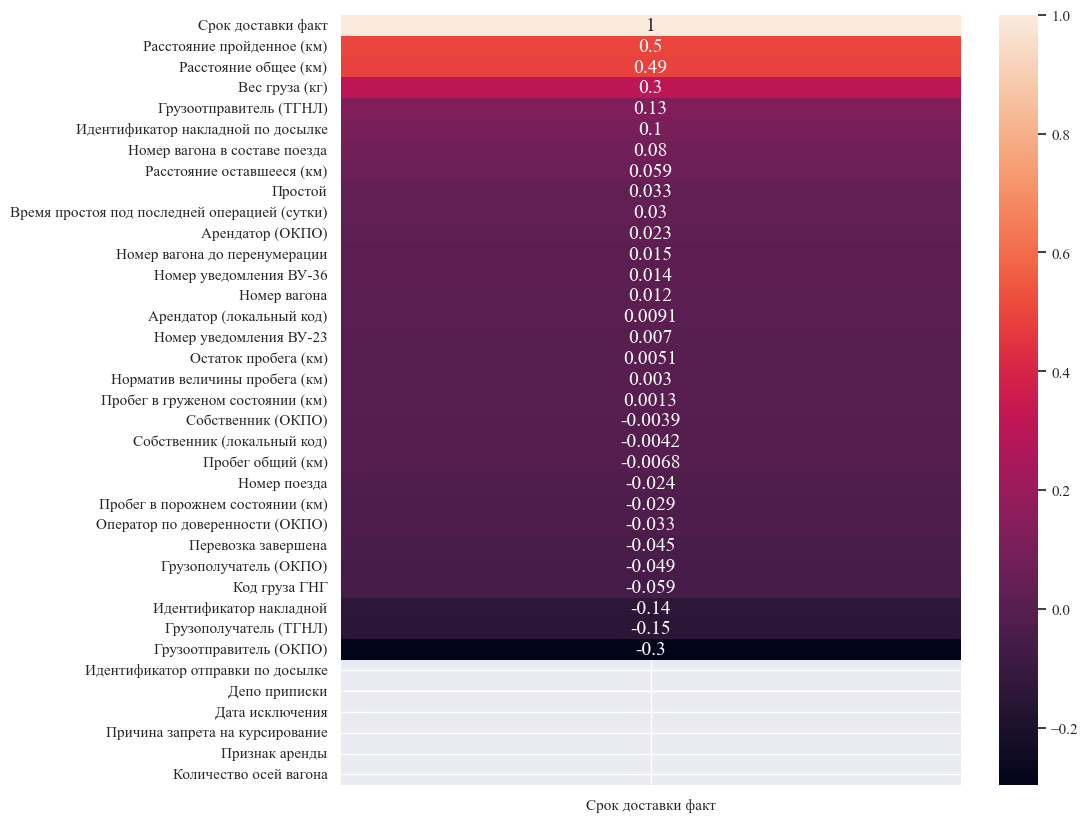

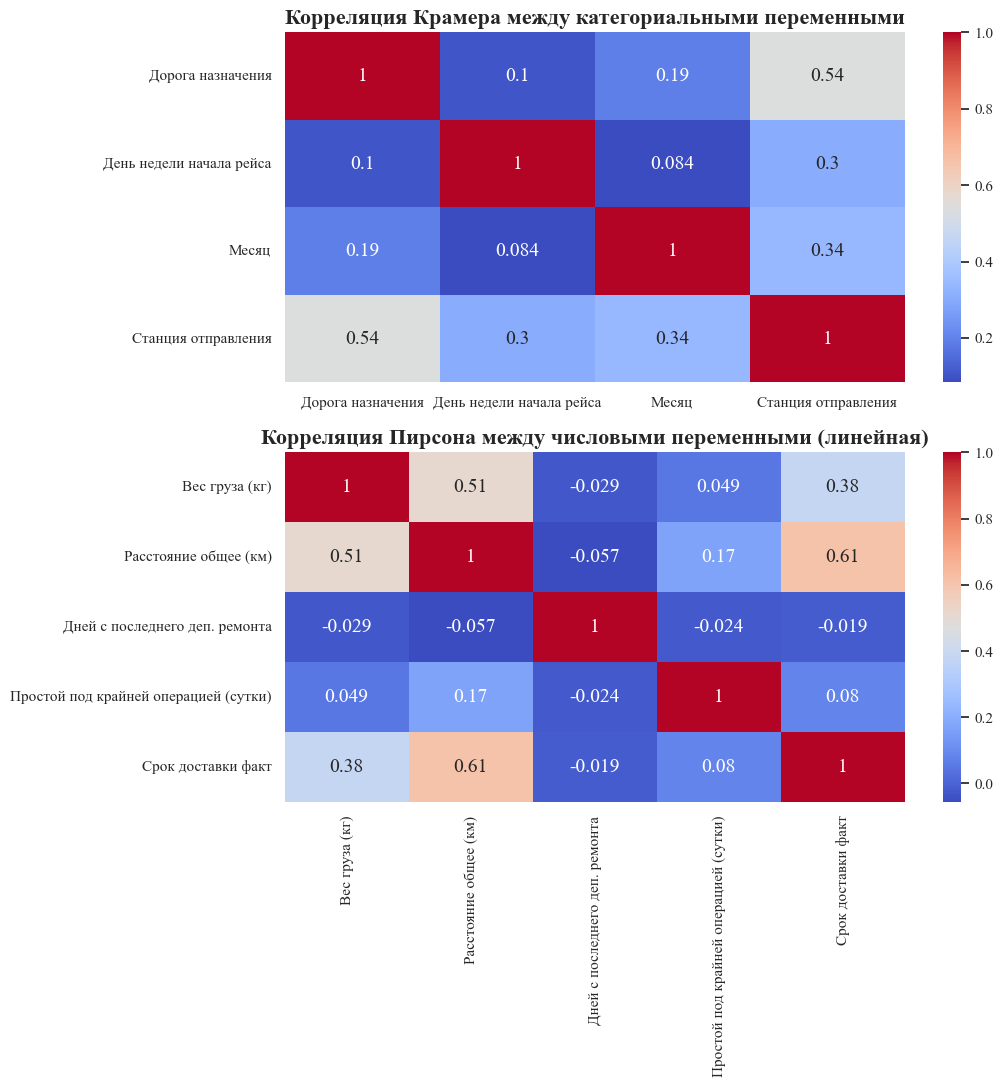

In [121]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

sns.heatmap(cramers_corr_matrix(df_cleaned[categorical_features]).astype(float), annot=True, ax=axes[0], cmap='coolwarm')
axes[0].set_title('Корреляция Крамера между категориальными переменными', weight='bold')

corr_matrix = df_cleaned[continuous_features + [target]].corr()
sns.heatmap(corr_matrix, annot=True, ax=axes[1], cmap='coolwarm')                   # -> Мультиколлинеарности нет 
axes[1].set_title('Корреляция Пирсона между числовыми переменными (линейная)', weight='bold')

plt.show()

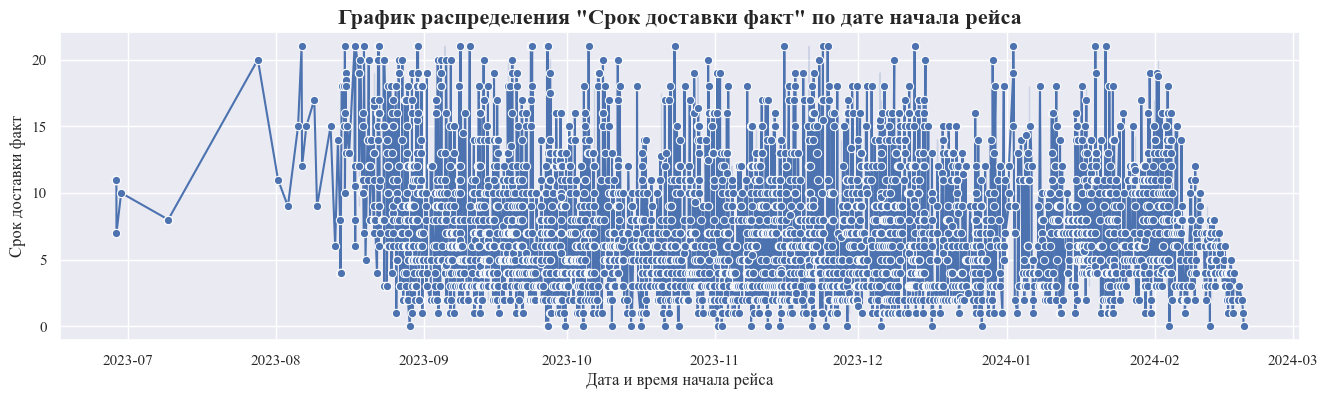

In [122]:
df_sorted = df_cleaned.sort_values(by=['Дата и время начала рейса', 'Срок доставки факт'])

# Построение графика
plt.figure(figsize=(16, 4))
plt.title('График распределения "Cрок доставки факт" по дате начала рейса', weight='bold')
sns.lineplot(
    x='Дата и время начала рейса', 
    y='Срок доставки факт',
    data=df_sorted,
    marker='o'
)
plt.show()

### Но сначала надо узнать имеют ли смысл аномальные значения, строим модель классификатор предсказания аномалия это или нет

In [123]:
"""# Классификатор предсказывает аномалию или нет 

X = df_cleaned[binary_features + categorical_features + continuous_features]
y = df_cleaned['is_anomaly']

target_encoder = TargetEncoder(cols=categorical_high_features)

X[categorical_high_features] = target_encoder.fit_transform(X[categorical_high_features], y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat_mid', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), categorical_mid_features),
        ('cat_low', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), categorical_low_features),
        ('binary', 'passthrough', binary_features),
        ('cat_high', 'passthrough', categorical_high_features)
    ],
    remainder='passthrough'
)

models = {
    'LinearRegression': LogisticRegression(penalty='l2', C=1.0, solver='liblinear') ,
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
}

results = {}

for name, reg in models.items():
       
    cls = Pipeline([
        ('preprocessor', preprocessor),
        ('cls', reg)
    ])

    cls.fit(X_train, y_train)

    y_pred = cls.predict(X_test)
    y_prob = cls.predict_proba(X_test)[:, 1]
    y_pred_new = (y_prob > 0.3).astype(int)

    print(f'Результат предсказаний классификатора {name}:')
    print(classification_report(y_test, y_pred_new, digits=3))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))"""

'# Классификатор предсказывает аномалию или нет \n\nX = df_cleaned[binary_features + categorical_features + continuous_features]\ny = df_cleaned[\'is_anomaly\']\n\ntarget_encoder = TargetEncoder(cols=categorical_high_features)\n\nX[categorical_high_features] = target_encoder.fit_transform(X[categorical_high_features], y)\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\npreprocessor = ColumnTransformer(\n    transformers=[\n        (\'num\', StandardScaler(), continuous_features),\n        (\'cat_mid\', OneHotEncoder(drop=\'first\', handle_unknown=\'infrequent_if_exist\'), categorical_mid_features),\n        (\'cat_low\', OneHotEncoder(drop=\'first\', handle_unknown=\'infrequent_if_exist\'), categorical_low_features),\n        (\'binary\', \'passthrough\', binary_features),\n        (\'cat_high\', \'passthrough\', categorical_high_features)\n    ],\n    remainder=\'passthrough\'\n)\n\nmodels = {\n    \'LinearRegression\': LogisticRegression

## Подготовка данных

In [124]:
# Подготовка данных
X = df_cleaned[binary_features + categorical_features + continuous_features]
y = df_cleaned[target]

### Борьба с неравномерным (логнормальным) распеределением целевой переменной

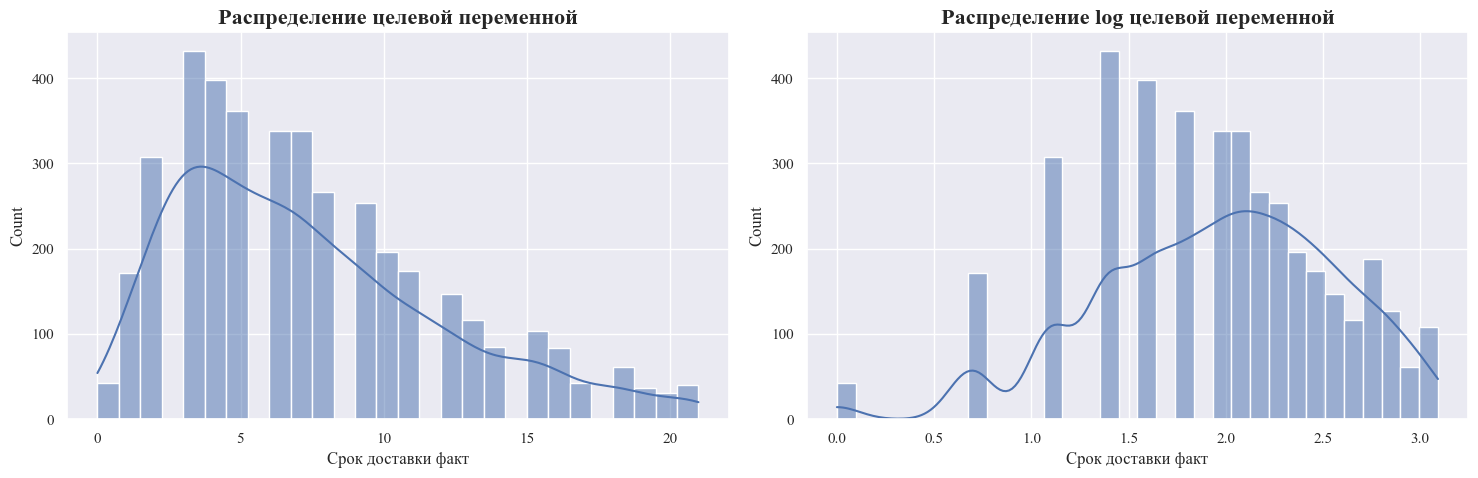

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(y, kde=True, ax=axes[0])
axes[0].set_title('Распределение целевой переменной', weight='bold')

# Используем логарифмирование
y_transformed = np.log1p(y)

sns.histplot(y_transformed, kde=True, ax=axes[1])
axes[1].set_title('Распределение log целевой переменной', weight='bold')

plt.tight_layout()
plt.show()

## Разделение на выборки

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.3, random_state=42)

#### Кодирование переменных с высокой кардинальностью

In [127]:
target_encoder = TargetEncoder(cols=categorical_high_features)

X_train[categorical_high_features] = target_encoder.fit_transform(X_train[categorical_high_features], y_train)
X_test[categorical_high_features] = target_encoder.transform(X_test[categorical_high_features])

In [128]:
"""transformed_data = preprocessor.fit_transform(X_train).toarray()  # Явное преобразование в dense array
transformed_df = pd.DataFrame(transformed_data, columns=preprocessor.get_feature_names_out())

# Выводим результат
feature_names = transformed_df.columns
rddd = model_rf.named_steps['regressor'].feature_importances_[:373]
print(len(rddd), len(feature_names))

# 6. Связываем имена признаков с их важностью
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': rddd
}).sort_values('importance', ascending=False)

feature_importances.head(10)"""

"transformed_data = preprocessor.fit_transform(X_train).toarray()  # Явное преобразование в dense array\ntransformed_df = pd.DataFrame(transformed_data, columns=preprocessor.get_feature_names_out())\n\n# Выводим результат\nfeature_names = transformed_df.columns\nrddd = model_rf.named_steps['regressor'].feature_importances_[:373]\nprint(len(rddd), len(feature_names))\n\n# 6. Связываем имена признаков с их важностью\nfeature_importances = pd.DataFrame({\n    'feature': feature_names,\n    'importance': rddd\n}).sort_values('importance', ascending=False)\n\nfeature_importances.head(10)"

## AutoML

In [129]:
automl = AutoML()

# Настройка
automl.fit(
    X_train, y_train, 
    task="regression",
    metric='r2',      # метрика оптимизации
    time_budget=300,
    estimator_list=['catboost', 'xgboost', 'rf']  # какие модели тестировать
)

y_automl_pred = np.expm1(automl.predict(X_test))
y_test_orig = np.expm1(y_test) 

print("MAE:", mean_absolute_error(y_test_orig, y_automl_pred))
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_orig, y_automl_pred)):.2f}")
print(f"R²: {r2_score(y_test_orig, y_automl_pred):.2f}")

[flaml.automl.logger: 06-25 22:16:59] {1752} INFO - task = regression
[flaml.automl.logger: 06-25 22:16:59] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 06-25 22:16:59] {1862} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 06-25 22:16:59] {1979} INFO - List of ML learners in AutoML Run: ['catboost', 'xgboost', 'rf']
[flaml.automl.logger: 06-25 22:16:59] {2282} INFO - iteration 0, current learner catboost
[flaml.automl.logger: 06-25 22:17:26] {2417} INFO - Estimated sufficient time budget=271059s. Estimated necessary time budget=271s.
[flaml.automl.logger: 06-25 22:17:26] {2466} INFO -  at 27.1s,	estimator catboost's best error=0.3357,	best estimator catboost's best error=0.3357
[flaml.automl.logger: 06-25 22:17:26] {2282} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 06-25 22:17:26] {2466} INFO -  at 27.3s,	estimator xgboost's best error=0.7288,	best estimator catboost's best error=0.3357
[flaml.automl.logger: 06-25 22:17:26] {2282} INFO - i

## Построение модельки

### Берем за основу LinearRegression, RandomForest, XGBoost

### Основной препроцессор

In [130]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), categorical_low_features+categorical_mid_features),
        ('binary', 'passthrough', binary_features),
    ],
    remainder='passthrough'
)

### Простенькая моделька RandomForest без логарифмирования целевой

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

target_encoder = TargetEncoder(cols=categorical_high_features)
X_train[categorical_high_features] = target_encoder.fit_transform(X_train[categorical_high_features], y_train)
X_test[categorical_high_features] = target_encoder.transform(X_test[categorical_high_features])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print(f"R²: {r2_score(y_test, y_pred):.2f}")

MAE: 1.8573200992555832
R²: 0.67


d:\Загрузки\Петуны\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Простенькая моделька RandomForest С логарифмированием целевой

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.3, random_state=42)

target_encoder = TargetEncoder(cols=categorical_high_features)
X_train[categorical_high_features] = target_encoder.fit_transform(X_train[categorical_high_features], y_train)
X_test[categorical_high_features] = target_encoder.transform(X_test[categorical_high_features])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

model.fit(X_train, y_train)
y_pred = np.expm1(model.predict(X_test))
y_test_orig = np.expm1(y_test)

print("MAE:", mean_absolute_error(y_test_orig, y_pred))
print(f"R²: {r2_score(y_test_orig, y_pred):.2f}")

MAE: 1.8343028803508243
R²: 0.64


d:\Загрузки\Петуны\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### GridSearch

### Для RandomForest и XGBoost

In [133]:
param_grids = {
    'RandomForest': {'regressor__max_depth': [None], 'regressor__min_samples_split': [2], 'regressor__n_estimators': [300]},
    'XGBoost': { 
        'regressor__reg_lambda': [0.1], 
         'regressor__reg_alpha': [0.1], 
         'regressor__n_estimators': [200, 300],
         'regressor__max_depth': [7, 9], 
         'regressor__max_delta_step': [1], 
         'regressor__learning_rate': [0.1, 0.05]
    }
}

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

results = {}
best_models = {}

for name, reg in models.items():
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', reg)
    ])
    
    for scoring in ['r2']:
        
        if name not in param_grids: # Для LinearRegression не делаем GridSearch
            model.fit(X_train, y_train)
            best_models[name] = model
        else:
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grids[name],
                cv=5,
                scoring=scoring,
                n_jobs=-1,
                verbose=1
            )
             
            grid_search.fit(X_train, y_train)
            
            model = grid_search.best_estimator_
            
            best_models[name] = model
            
            print(f"\nBest parameters while scoring - {scoring} for {name}:")
            print(grid_search.best_params_)

    
        y_pred = np.expm1(model.predict(X_test))
        y_test_orig = np.expm1(y_test)
        
        results[name] = {
            'scoring': scoring,
            'MAE': mean_absolute_error(y_test_orig, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test_orig, y_pred)),
            'R2': r2_score(y_test_orig, y_pred)
        }

for name, metrics in results.items():
    print(f"\n{name}:")
    for metric_name, value in metrics.items():
        if metric_name != 'scoring':
            print(f"  {metric_name}: {value:.3f}")
        else:
            print(f"  scoring: {metric_name}")

d:\Загрузки\Петуны\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters while scoring - r2 for RandomForest:
{'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


d:\Загрузки\Петуны\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Best parameters while scoring - r2 for XGBoost:
{'regressor__learning_rate': 0.1, 'regressor__max_delta_step': 1, 'regressor__max_depth': 7, 'regressor__n_estimators': 300, 'regressor__reg_alpha': 0.1, 'regressor__reg_lambda': 0.1}

LinearRegression:
  scoring: scoring
  MAE: 2.424
  RMSE: 3.561
  R2: 0.436

RandomForest:
  scoring: scoring
  MAE: 1.828
  RMSE: 2.818
  R2: 0.647

XGBoost:
  scoring: scoring
  MAE: 1.944
  RMSE: 2.883
  R2: 0.630


d:\Загрузки\Петуны\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Метамодель

d:\Загрузки\Петуны\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\Загрузки\Петуны\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Stacked LinearRegression:
  MAE: 1.850
  MSE: 2.849
  R2: 0.639


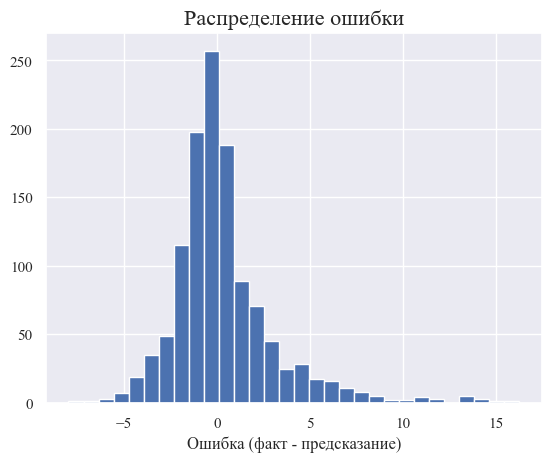

d:\Загрузки\Петуны\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\Загрузки\Петуны\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Stacked RandomForestRegressor:
  MAE: 1.867
  MSE: 2.884
  R2: 0.630


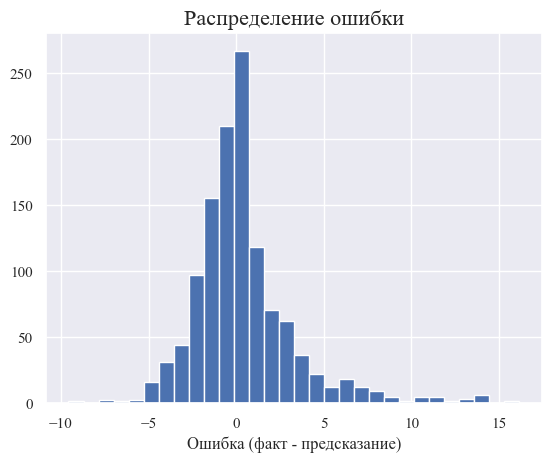

d:\Загрузки\Петуны\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\Загрузки\Петуны\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Stacked XGBRegressor:
  MAE: 1.875
  MSE: 2.910
  R2: 0.623


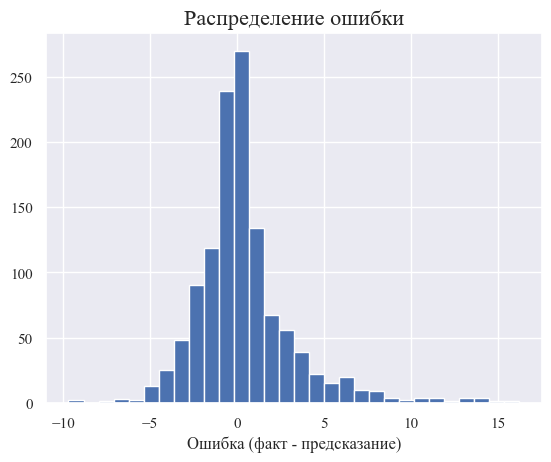

In [134]:
def metamodeling(metamodel):
    rf_train_pred = best_models['RandomForest'].predict(X_train)
    xgb_train_pred = best_models['XGBoost'].predict(X_train)

    meta_X_train = np.column_stack([rf_train_pred, xgb_train_pred])
    
    meta_model = metamodel
    meta_model.fit(meta_X_train, y_train)

    rf_test_pred = best_models['RandomForest'].predict(X_test)
    xgb_test_pred = best_models['XGBoost'].predict(X_test)
    meta_X_test = np.column_stack([rf_test_pred, xgb_test_pred])

    meta_pred_log = meta_model.predict(meta_X_test)
    meta_pred = np.expm1(meta_pred_log)
    y_test_orig = np.expm1(y_test)
        
    print(f"\nStacked {metamodel.__class__.__name__}:")
    print(f"  MAE: {mean_absolute_error(y_test_orig, meta_pred):.3f}")
    print(f"  MSE: {np.sqrt(mean_squared_error(y_test_orig, meta_pred)):.3f}")
    print(f"  R2: {r2_score(y_test_orig, meta_pred):.3f}")

    errors = y_test_orig - meta_pred
    plt.hist(errors, bins=30)
    plt.title("Распределение ошибки")
    plt.xlabel("Ошибка (факт - предсказание)")
    plt.show()
    
    
for metamodel in [LinearRegression(), RandomForestRegressor(), XGBRegressor()]:
    metamodeling(metamodel)


## Глобальная интерпретация
### **SHAP**

In [135]:
preprocessor = best_models['RandomForest'].named_steps['preprocessor']
rf_model = best_models['RandomForest'].named_steps['regressor']

X_test_processed = preprocessor.transform(X_test).astype(np.float64)

if hasattr(X_test_processed, 'toarray'):
    X_test_processed = X_test_processed.toarray()

feature_names = preprocessor.get_feature_names_out()

d:\Загрузки\Петуны\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


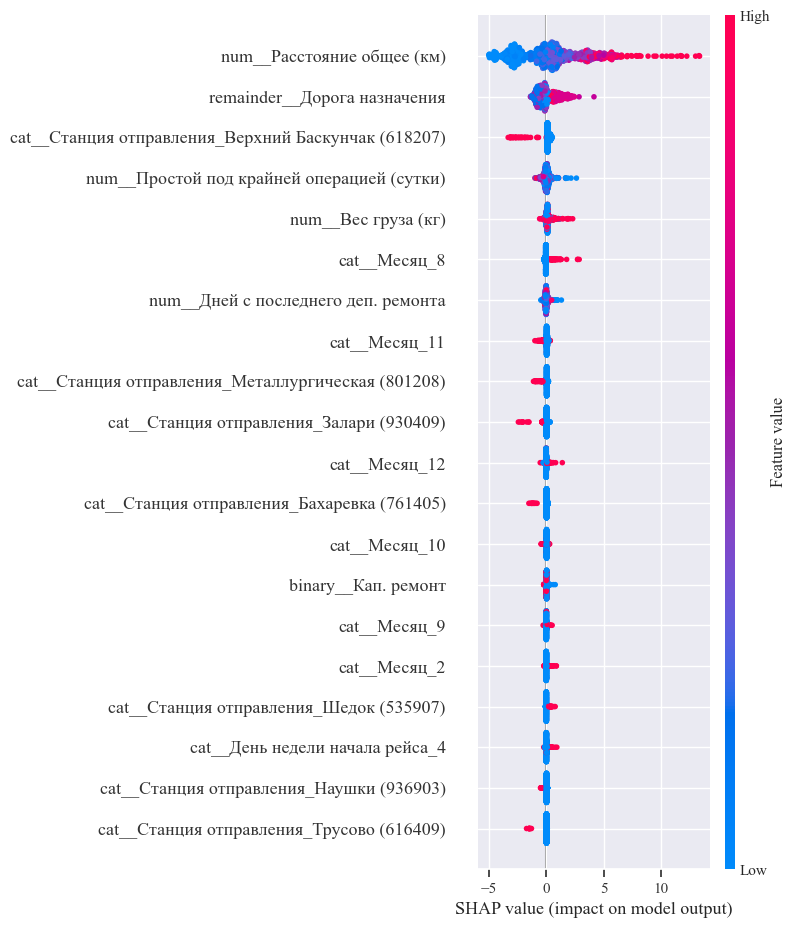

In [136]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_processed)
shap_values_orig = np.expm1(explainer.expected_value + shap_values) - np.expm1(explainer.expected_value)

shap.summary_plot(shap_values_orig, X_test_processed, feature_names=feature_names)

### Среднее абсолютное SHAP

In [137]:
shap_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': np.mean(np.abs(shap_values), axis=0)  # среднее |SHAP|
})

shap_df.sort_values('mean_abs_shap', ascending=False, inplace=True)
shap_df.head(10)

,feature,mean_abs_shap
1,num__Расстояние общее (км),0.333850
248,remainder__Дорога назначения,0.087568
46,cat__Станция отправления_Верхний Баскунчак (61...,0.044108
3,num__Простой под крайней операцией (сутки),0.026011
0,num__Вес груза (кг),0.024487
16,cat__Месяц_8,0.014402
2,num__Дней с последнего деп. ремонта,0.013430
11,cat__Месяц_11,0.011778
143,cat__Станция отправления_Металлургическая (801...,0.011025
82,cat__Станция отправления_Залари (930409),0.010343


### **Визуализация дерева решений**

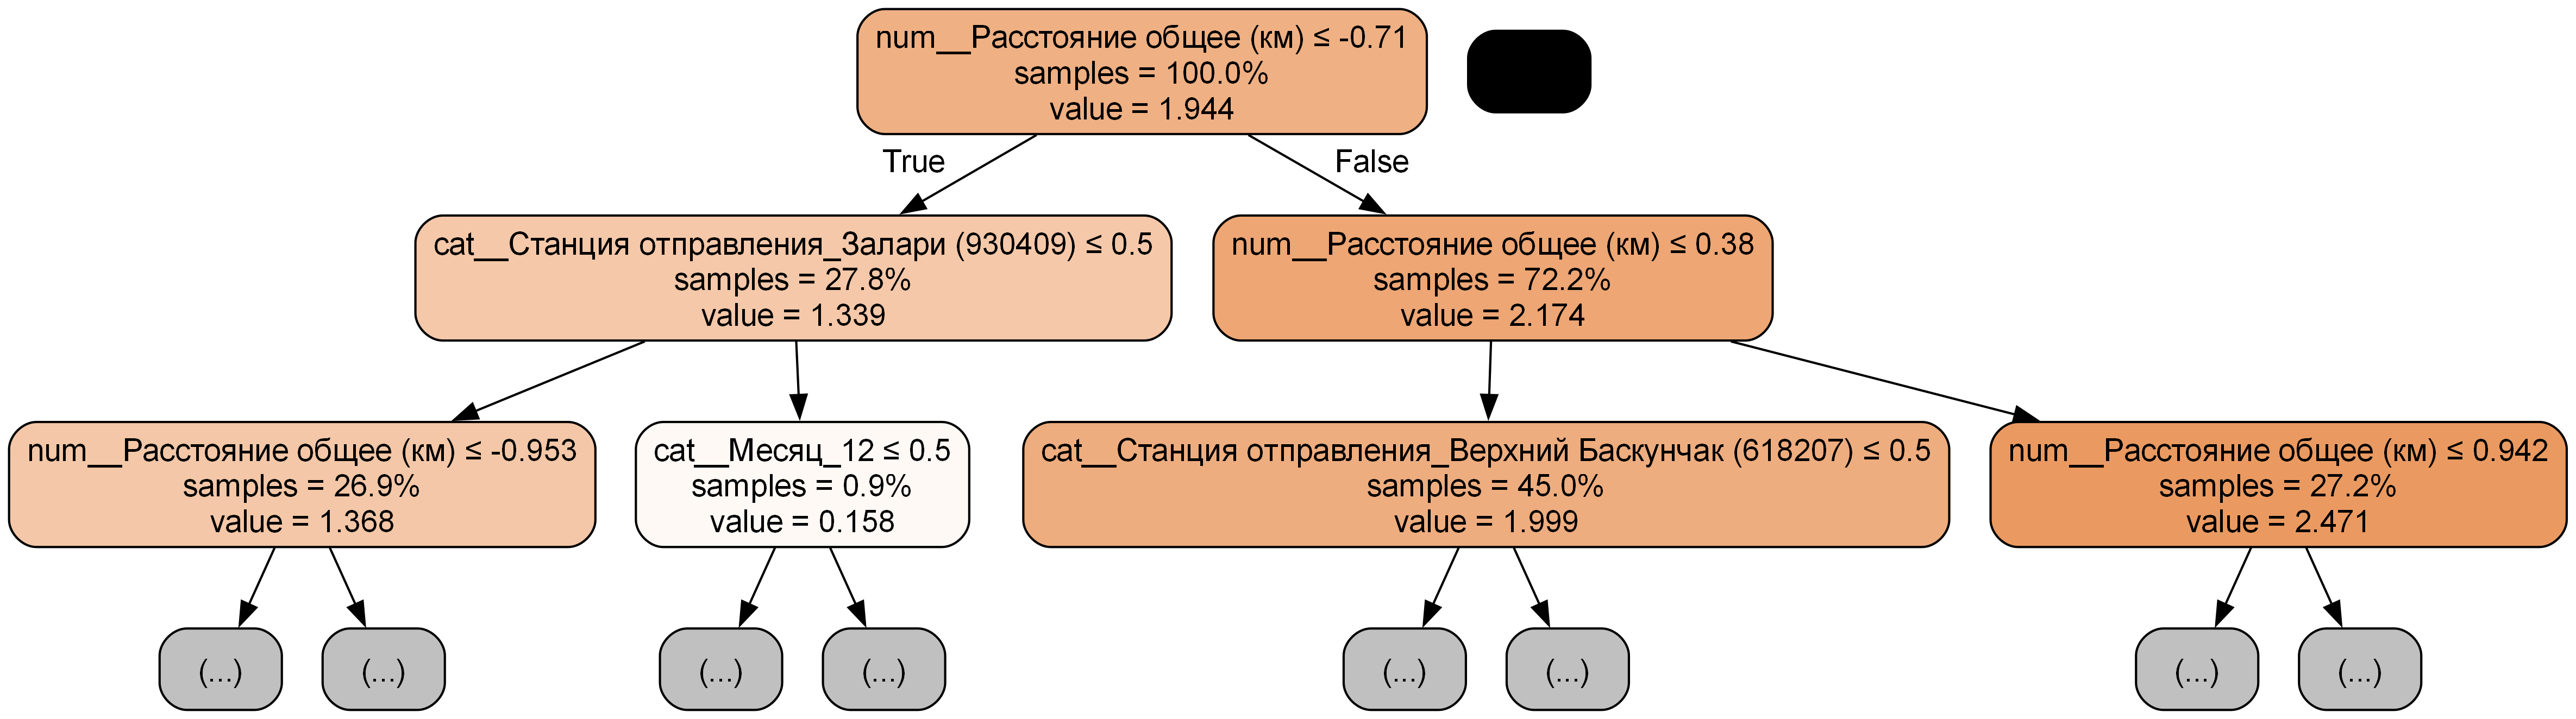

In [138]:
# Одно дерево
tree = rf_model.estimators_[0]

# Экспортируем дерево в DOT формат
dot_data = export_graphviz(
    tree,
    out_file=None,  # Не сохранять в файл
    feature_names=feature_names,  # Имена признаков
    class_names=True,  # Для классификации - имена классов
    filled=True,       # Заливка цветом
    rounded=True,      # Закругленные углы
    special_characters=True,
    proportion=True,   # Показывать пропорции вместо количеств
    impurity=False,    # Не показывать impurity (для читаемости)
    max_depth=2        # Ограничить глубину визуализации
)

graph = pydotplus.graph_from_dot_data(dot_data)

graph.set_size('"20,20"')  # Размер изображения
graph.set_dpi(300)         # Качество изображения

output_path = "tree_visualization.png"
graph.write_png(output_path)  # Сохраняем в файл
display(Image(filename=output_path))   # Отображаем в ноутбуке

# Временные файлы удаляем
os.remove(output_path)

## Локальная интерпретация

### Ищу интересные наблюдения
#### 1) С максимальным/минимальным прогнозом
#### 2) С самой большой ошибкой прогноза

In [139]:
# Получаем прогнозы для тестовой выборки
y_pred = np.expm1(rf_model.predict(X_test_processed))
y_test_orig = np.expm1(y_test)

In [140]:
explainer = shap.TreeExplainer(rf_model)
shap_values_log = explainer.shap_values(X_test_processed)

# Для регрессии shap_values_log может быть 2D-массивом (n_samples, n_features)
if isinstance(shap_values_log, list):
    shap_values_log = shap_values_log[0]  # Берем значения для единственного выхода

# 2. Базовое значение (ожидаемое значение модели)
base_value_log = explainer.expected_value
if isinstance(base_value_log, np.ndarray):
    base_value_log = base_value_log[0]  # Берем первое значение если массив

print(f"Базовое значение (log): {base_value_log:.4f}")

# 3. Преобразование в исходную шкалу
def inverse_transform_shap(base, shap_vals):
    """Преобразует SHAP-значения из логарифмической шкалы в исходную"""
    return np.expm1(base + shap_vals) - np.expm1(base)

# Для всего набора данных
shap_values_orig = inverse_transform_shap(base_value_log, shap_values_log)

# 4. Проверка на конкретном наблюдении (с максимальным предсказанием)
max_pred_idx = np.argmax(y_pred)
sample_shap = shap_values_log[max_pred_idx]
sample_pred_log = base_value_log + sample_shap.sum()
sample_pred_orig = np.expm1(sample_pred_log)

print("\nПроверка согласованности:")
print(f"Предсказание модели (original): {y_pred[max_pred_idx]:.2f}")
print(f"SHAP сумма (original): {sample_pred_orig:.2f}")
print(f"Фактическое значение: {y_test_orig.iloc[max_pred_idx]:.2f}")

Базовое значение (log): 1.9444

Проверка согласованности:
Предсказание модели (original): 20.86
SHAP сумма (original): 20.86
Фактическое значение: 21.00


### Waterfall Plot

Максимальное предсказание:
   Базовое значение: 5.99
   SHAP сумма (original): 20.86
   Фактическое значение: 21.00


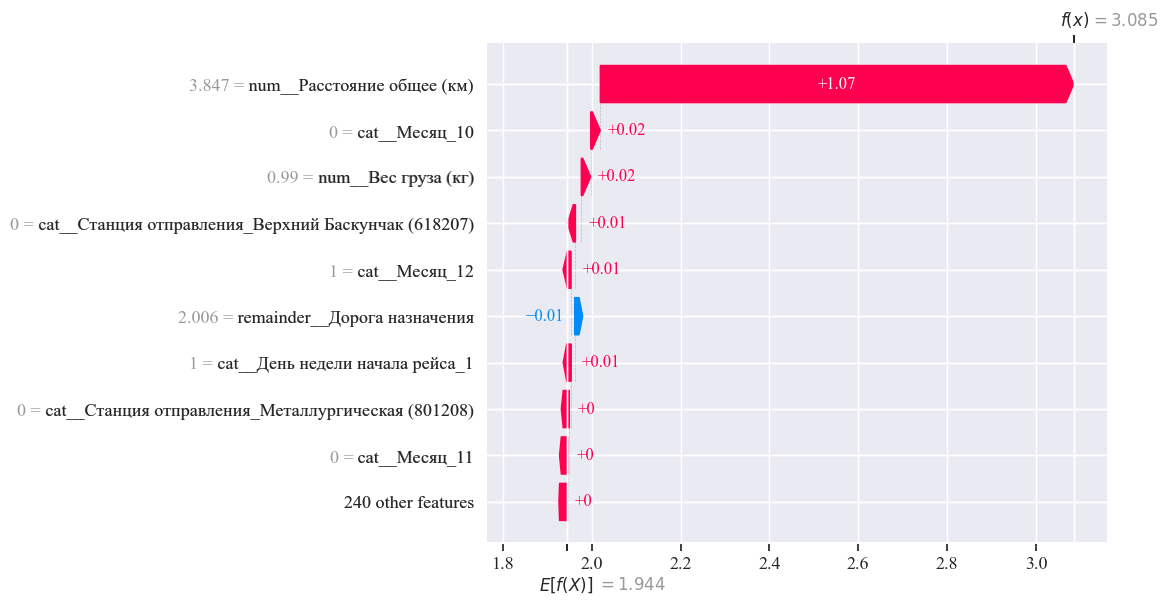

Минимальное предсказание:
   Базовое значение: 5.99
   SHAP сумма (original): 0.01
   Фактическое значение: 0.00


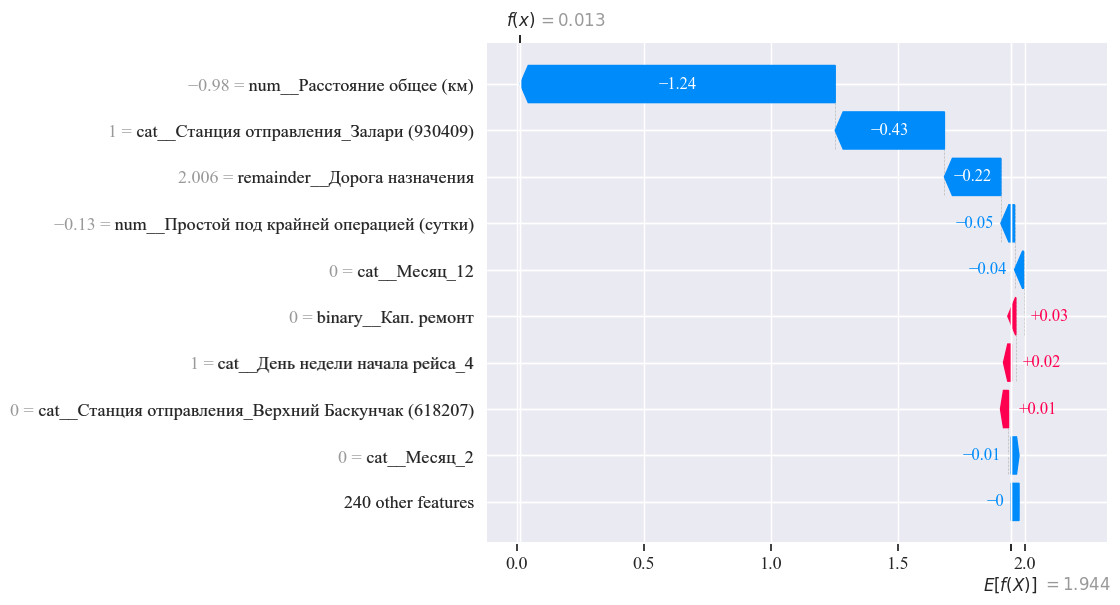

Предсказание с самой большой ошибкой:
   Базовое значение: 5.99
   SHAP сумма (original): 3.92
   Фактическое значение: 20.00


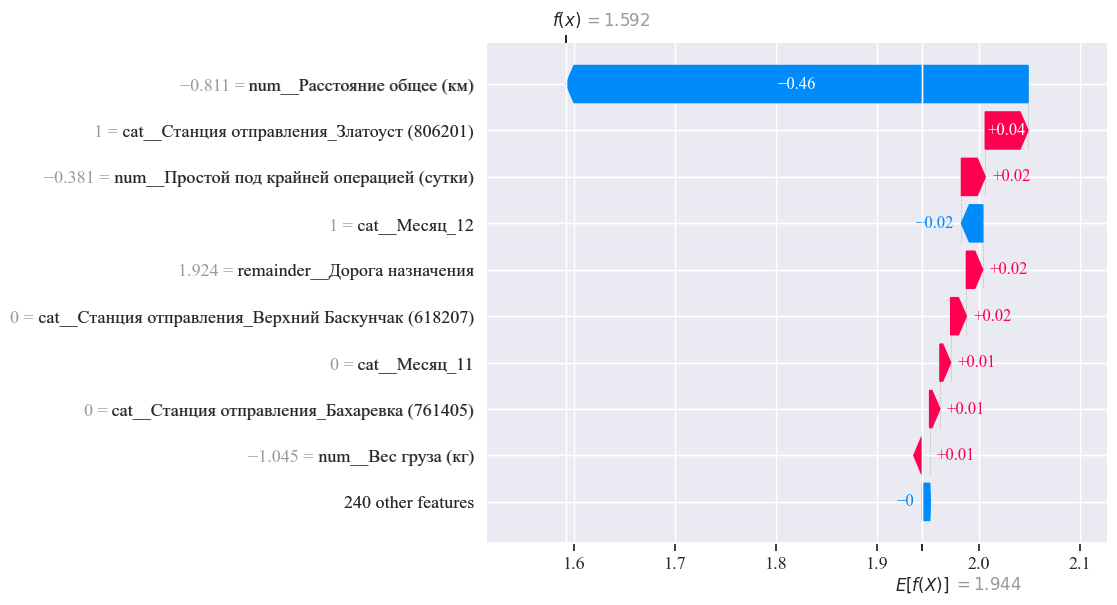

In [141]:
# Преобразуем y_test_orig в numpy array
y_test_orig_values = y_test_orig.values if hasattr(y_test_orig, 'values') else y_test_orig

# Находим интересные наблюдения
max_pred_idx = np.argmax(y_pred)
min_pred_idx = np.argmin(y_pred)
max_error_idx = np.argmax(np.abs(y_pred - y_test_orig_values))

# Waterfall plot #
# Макс предсказание
sample_shap = shap_values_log[max_pred_idx]
sample_pred_log = base_value_log + sample_shap.sum()
sample_pred_orig = np.expm1(sample_pred_log)
print(f"Максимальное предсказание:")
print(f"   Базовое значение: {np.expm1(base_value_log):.2f}")
print(f"   SHAP сумма (original): {sample_pred_orig:.2f}")
print(f"   Фактическое значение: {y_test_orig.iloc[max_pred_idx]:.2f}")
shap.plots.waterfall(shap.Explanation(
    values=shap_values[max_pred_idx],
    base_values=explainer.expected_value,
    data=X_test_processed[max_pred_idx],
    feature_names=feature_names
))

# Мин предсказание
sample_shap = shap_values_log[min_pred_idx]
sample_pred_log = base_value_log + sample_shap.sum()
sample_pred_orig = np.expm1(sample_pred_log)
print(f"Минимальное предсказание:")
print(f"   Базовое значение: {np.expm1(base_value_log):.2f}")
print(f"   SHAP сумма (original): {sample_pred_orig:.2f}")
print(f"   Фактическое значение: {y_test_orig.iloc[min_pred_idx]:.2f}")
shap.plots.waterfall(shap.Explanation(
    values=shap_values[min_pred_idx],
    base_values=explainer.expected_value,
    data=X_test_processed[min_pred_idx],
    feature_names=feature_names
))

# С самой большой ошибкой предсказание
sample_shap = shap_values_log[max_error_idx]
sample_pred_log = base_value_log + sample_shap.sum()
sample_pred_orig = np.expm1(sample_pred_log)
print(f"Предсказание с самой большой ошибкой:")
print(f"   Базовое значение: {np.expm1(base_value_log):.2f}")
print(f"   SHAP сумма (original): {sample_pred_orig:.2f}")
print(f"   Фактическое значение: {y_test_orig.iloc[max_error_idx]:.2f}")
shap.plots.waterfall(shap.Explanation(
    values=shap_values[max_error_idx],
    base_values=explainer.expected_value,
    data=X_test_processed[max_error_idx],
    feature_names=feature_names
))

### Optuna для Random Forest и XGBoost 

In [142]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective_rf(trial):
    params = {
        'regressor__n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'regressor__max_depth': trial.suggest_int('max_depth', 3, 30),
        'regressor__min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'regressor__min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'regressor__max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'regressor__bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])
    
    model.set_params(**params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='r2', n_jobs=-1).mean()
    return score


In [143]:
def objective_xgb(trial):
    params = {
        'xgb__n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'xgb__learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'xgb__max_depth': trial.suggest_int('max_depth', 3, 15),
        'xgb__reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'xgb__reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'xgb__gamma': trial.suggest_float('gamma', 0, 5),
        'xgb__subsample': trial.suggest_float('subsample', 0.6, 1),
        'xgb__colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1)
    }
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('xgb', XGBRegressor(random_state=42))
    ])
    
    model.set_params(**params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='r2', n_jobs=-1).mean()
    return score

In [144]:
# Для RandomForest
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=150)

# Для XGBoost
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=150)

[I 2025-06-25 22:31:04,339] A new study created in memory with name: no-name-3d06e45e-a6c2-420f-845e-d69262ffd940
[I 2025-06-25 22:31:09,048] Trial 0 finished with value: 0.3943652432656326 and parameters: {'n_estimators': 315, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.3943652432656326.
[I 2025-06-25 22:31:21,868] Trial 1 finished with value: 0.5656348369916914 and parameters: {'n_estimators': 290, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': False}. Best is trial 1 with value: 0.5656348369916914.
[I 2025-06-25 22:31:25,085] Trial 2 finished with value: 0.37879702846393243 and parameters: {'n_estimators': 429, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.5656348369916914.
[I 2025-06-25 22:31:25,700] Trial 3 finished with value: 0.2492775534974417

KeyboardInterrupt: 

In [ ]:
# Лучшая модель RandomForest
best_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(**study_rf.best_params, random_state=42))
])

# Лучшая модель XGBoost
best_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBRegressor(**study_xgb.best_params, random_state=42))
])

In [ ]:
# Обучение и оценка лучших моделей
best_rf.fit(X_train, y_train)
best_xgb.fit(X_train, y_train)

y_pred_rf = best_rf.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)

print("RF Test score:", best_rf.score(X_test, y_test))
print("XGB Test score:", best_xgb.score(X_test, y_test))

RF Test score: 0.03161038944768979
XGB Test score: 0.021663963794708252


c:\Users\annas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\annas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\annas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\annas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encode

In [ ]:
print("MAE RF:", mean_absolute_error(y_test, y_pred_rf))
print("MAE XGB:", mean_absolute_error(y_test, y_pred_xgb))
print(f"RMSE RF: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")
print(f"RMSE XGB: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")
print(f"R² RF: {r2_score(y_test, y_pred_rf):.2f}")
print(f"R² XGB: {r2_score(y_test, y_pred_xgb):.2f}")

MAE RF: 0.08760786883946396
MAE XGB: 0.08538924157619476
RMSE RF: 0.21
RMSE XGB: 0.21
R² RF: 0.03
R² XGB: 0.02


In [ ]:
# Получаем предсказания для тренировочных данных
rf_train_pred = best_rf.predict(X_train)
xgb_train_pred = best_xgb.predict(X_train)

stacked_features = np.column_stack([rf_train_pred, xgb_train_pred])

# Обучаем мета-модели:
# 1) Мета модель Линейная регресиия
meta_model = LinearRegression()
meta_model.fit(stacked_features, y_train)

# Предсказание на тесте
stacked_test = np.column_stack([y_pred_rf, y_pred_xgb])
final_pred = meta_model.predict(stacked_test)

# Оценка
print("MAE:", mean_absolute_error(y_test, final_pred))
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, final_pred)):.2f}")
print(f"R²: {r2_score(y_test, final_pred):.5f}")


MAE: 0.08278066657238804
RMSE: 0.20
R²: 0.10727


In [ ]:
# 2) Мета модель Градиентный бустинг

train_meta = np.column_stack([rf_train_pred, xgb_train_pred])
test_meta = np.column_stack([y_pred_rf, y_pred_xgb])

meta_model = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
meta_model.fit(train_meta, y_train)
final_pred = meta_model.predict(test_meta)

# Оценка
print("MAE:", mean_absolute_error(y_test, final_pred))
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, final_pred)):.2f}")
print(f"R²: {r2_score(y_test, final_pred):.2f}")

MAE: 0.06258604675531387
RMSE: 0.20
R²: 0.12


In [ ]:
"""rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=300, min_samples_split=2, max_depth=None, random_state=42))
])"""

"rf_model = Pipeline([\n    ('preprocessor', preprocessor),\n    ('regressor', RandomForestRegressor(n_estimators=300, min_samples_split=2, max_depth=None, random_state=42))\n])"

In [ ]:
"""xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBRegressor(random_state=42, n_estimators=300, learning_rate=0.05, max_delta_step=1, max_depth=9,
                         reg_alpha=0.1, reg_lambda=0.1))
])"""

"xgb_model = Pipeline([\n    ('preprocessor', preprocessor),\n    ('xgb', XGBRegressor(random_state=42, n_estimators=300, learning_rate=0.05, max_delta_step=1, max_depth=9,\n                         reg_alpha=0.1, reg_lambda=0.1))\n])"

In [ ]:
"""X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)"""

'X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)\nxgb_model.fit(X_train, y_train)\ny_pred = xgb_model.predict(X_test)'